# Lab 4

## Task 1

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as p
import math
import numdifftools as ndt
from dataclasses import dataclass
from functools import partial
from collections import deque
import time
import scipy
import tracemalloc

In [2]:
eps = 1e-6

In [3]:
def grad(f, x: np.ndarray):
    g = ndt.Gradient(f)
    return g(x)

def jacobian(f, x: np.ndarray):
    j = ndt.Jacobian(f)
    return j(x)


def hessian(f, x: np.ndarray):
    h = ndt.Hessian(f)
    return h(x)

def wolfe(f, x: np.ndarray, alpha, direction, c1=0.1, c2=0.9):
    gx = grad(f, x)
    cond1 = f(x + alpha * direction) <= f(x) + \
        alpha * c1 * np.dot(direction, gx)
    cond2 = abs(np.dot(direction, grad(f, x + alpha * direction))
                ) <= abs(c2 * np.dot(direction, gx))
    return cond1 and cond2


def find_wolfe(f, x: np.ndarray, direction):
    m = mk = 1
    start_alpha = 0.5
    for m in range(1, 10):
        alpha = start_alpha ** m
        if wolfe(f, x, alpha, direction):
            mk = m
            break
    return start_alpha ** mk

def sgd(f, x, lr, lim=500):
    return momentum_gd(f, x, lr, 0, lim=lim)


def momentum_gd(f, x, lr, momentum, lim=500):
    n = len(x)
    points = []
    points.append(x)
    v = np.array([0] * len(x))

    while True:
        v = momentum * v - lr * (g := grad(f, x))

        if np.linalg.norm(v) < eps:
            break
        x = x + v

        points.append(x)

        if len(points) >= lim:
            break

    return np.array(points)


def nesterov_gd(f, x, lr, momentum, lim=500):
    n = len(x)
    points = []
    points.append(x)
    v = np.array([0] * len(x))
    while True:
        v = momentum * v + (g := grad(f, x))
        delta = - lr * (g + momentum * v)
        if np.linalg.norm(delta) < eps:
            break
        x = x + delta

        points.append(x)

        if len(points) >= lim:
            break
    return np.array(points)


def adagrad(f, x, lr, lim=500):
    ee = 1e-8
    n = len(x)
    points = []
    points.append(x)
    G = 0
    while True:
        g = grad(f, x)
        G += np.dot(g, g)
        delta = - lr * g / np.sqrt(G + ee)
        if np.linalg.norm(delta) < eps:
            break
        x = x + delta

        points.append(x)

        if len(points) >= lim:
            break

    return np.array(points)


def rmsprop(f, x, lr, beta, lim=500):
    ee = 1e-8
    n = len(x)
    points = []
    points.append(x)
    s = 0
    while True:
        g = grad(f, x)
        s = s * beta + (1 - beta) * np.dot(g, g)
        delta = - lr * g / np.sqrt(s + ee)
        if np.linalg.norm(delta) < eps:
            break
        x = x + delta

        points.append(x)

        if len(points) >= lim:
            break

    return np.array(points)


def adam(f, x, lr, beta1, beta2, lim=500):
    ee = 1e-8
    n = len(x)
    points = []
    points.append(x)
    s = 0
    v = np.array([0] * n)
    while True:
        g = grad(f, x)
        v = v * beta1 + (1 - beta1) * g
        s = s * beta2 + (1 - beta2) * np.dot(g, g)
        v_ = v / (1 - beta1 ** len(points))
        s_ = s / (1 - beta2 ** len(points))
        delta = - lr * v_ / np.sqrt(s_ + ee)
        if np.linalg.norm(delta) < eps:
            break
        x = x + delta

        points.append(x)

        if len(points) >= lim:
            break

    return np.array(points)

def gen_points_with_source_f(count, disp, calc):
    return np.array(sorted([(x := 0.05 * np.random.rand() + (i - count / 2) / (count / 3), calc(x) + np.random.normal(scale=disp)) for i in range(count)], key=lambda x: x[0])), calc

def gen_loss(ps):
    def f(x): # loss
        p = len(x)
        return sum((ps[:, 1] - sum(x[i] * ps[:, 0] ** i for i in range(len(x)))) ** 2) / p

    return f

def bfgs_gd(f, x, lim=500):
    n = len(x)
    points = []
    g = None
    C = np.linalg.inv(hessian(f, x))
    points.append(x)
    while True:
        if g is None:
            g = grad(f, x)

        if np.linalg.norm(g) < eps:
            break

        p = -C @ g

        alpha = find_wolfe(f, x, p)
        delta = p * alpha
        x = x + delta
        points.append(x)

        if (len(points) > lim):
            break

        newg = grad(f, x)
        y = newg - g
        g = newg

        I = np.eye(n)
        rho = 1 / (y.T @ delta)
        C = (I - rho * np.outer(delta, y.T)) @ C @ (I - rho * np.outer(y, delta.T)) + \
            rho * np.outer(delta, delta.T)

    return np.array(points)

def l_bfgs_gd(f, x, m=8, lim=500):
    n = len(x)
    points = []
    rho_q = deque(maxlen=m)
    s_q = deque(maxlen=m)
    y_q = deque(maxlen=m)
    g = None
    points.append(x)
    while True:
        if g is None:
            g = grad(f, x)

        if np.linalg.norm(g) < eps:
            break

        alpha_q = []

        q = g
        for s, rho, y in zip(reversed(s_q), reversed(rho_q), reversed(y_q)):
            alpha = rho * np.outer(s.T, q)
            alpha_q.append(alpha)
            q = q - alpha @ y

        try:
            gamma = (s_q[-1].T @ y_q[-1]) / (y_q[-1].T @ y_q[-1])
            H = gamma * np.eye(n)
        except IndexError:
            H = np.linalg.inv(hessian(f, x))

        z = H @ q

        for s, rho, y, alpha in zip(s_q, rho_q, y_q, reversed(alpha_q)):
            beta = rho * np.outer(y.T, z)
            z = z + s @ (alpha - beta)

        p = -z
        alpha = find_wolfe(f, x, p)
        delta = p * alpha
        s_q.append(delta)
        x = x + delta
        points.append(x)

        if (len(points) > lim):
            break

        newg = grad(f, x)
        y = newg - g
        y_q.append(y)
        g = newg

        rho = 1 / (y.T @ delta)
        rho_q.append(rho)

    return np.array(points)


def gauss_newton(p, points, num_iters=100):
        w = np.zeros(p+1)
        A = np.array([[x ** i for i in range(p + 1)] for x in points[:, 0]])
        x = points[:, 0]
        y = points[:, 1]
        r = lambda w: y - np.array(sum(w[i] * x ** i for i in range(p + 1)))
        err = lambda w: sum(map(lambda ri: ri ** 2, r(w)))
        for cnt in range(num_iters):
            J = jacobian(r, w)

            delta = -(np.linalg.inv(J.T @ J) @ J.T @ r(w))
            
            prev_err = err(w)
            w += delta 
            # print(sum(w[i] * x ** i for i in range(p + 1)))

            if abs(err(w) - prev_err) < 1e-5:
                break

        return w, cnt

def dog_leg(p, points, trust_region=0.1, num_iters=100):
    def step(J, r: np.ndarray):
        gn_delta = -np.linalg.inv(J.T @ J) @ J.T @ r # gauss-newton
        if np.linalg.norm(gn_delta) <= trust_region:
            return gn_delta
        
        st_delta = -J.T @ r # gradient descent
        if np.linalg.norm(st_delta) > trust_region:
            return st_delta / np.linalg.norm(st_delta) * trust_region

        t = (np.linalg.norm(st_delta) / np.linalg.norm(J @ st_delta)) ** 2
        return t * st_delta + trust_region * (gn_delta - t * st_delta)
    
    w = np.zeros(p+1)
    A = np.array([[x ** i for i in range(p + 1)] for x in points[:, 0]])
    x = points[:, 0]
    y = points[:, 1]
    r = lambda w: y - np.array(sum(w[i] * x ** i for i in range(p + 1)))
    err = lambda w: sum(map(lambda ri: ri ** 2, r(w)))
    for cnt in range(num_iters):
        J = jacobian(r, w)

        delta = step(J, r(w))

        prev_err = err(w)
        w += delta 

        if abs(err(w) - prev_err) < 1e-5:
            break


    return w, cnt

def elastic_regression(p, ps, gd, alpha=0.5, lda=1):
    def f(x): # loss
        return sum((ps[:, 1] - sum(x[i] * ps[:, 0] ** i for i in range(len(x)))) ** 2) / p \
                + lda * (alpha * sum(map(abs, x)) + (1 - alpha) / 2 * sum(x ** 2))

    x = np.array([0.0] * (p + 1))
    return (points := gd(f, x)[-1]), len(points)
    

def poly_regression(p, points, gd):
    return elastic_regression(p, points, gd, 0, 0)


def l1_regression(p, points, gd, lda=1):
    return elastic_regression(p, points, gd, 0, lda)


def l2_regression(p, points, gd, lda=1):
    return elastic_regression(p, points, gd, 1, lda)


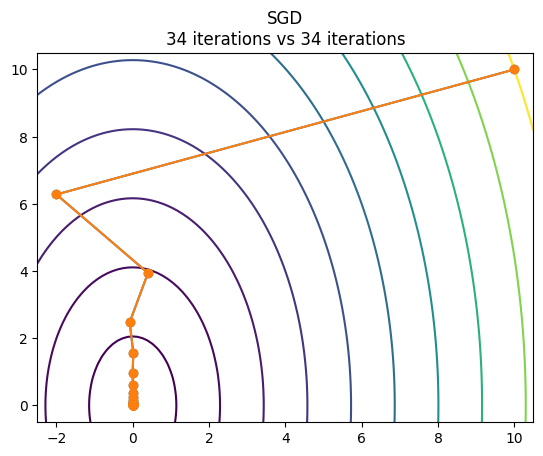

In [4]:
def run_torch_gd(params, f, xt, lim=500):
    optimizer = params([xt])
    prev = xt.clone()
    points = [xt.detach().numpy().copy()]
    for epoch in range(lim):
        optimizer.zero_grad()

        output = f(xt)
        output.backward()
        
        optimizer.step()
        delta = xt - prev

        if np.linalg.norm(delta.detach().numpy()) < eps:
            return np.array(points)
        prev = xt.clone()

        points.append(xt.detach().numpy().copy())

    return np.array(points)

class run_f:
    def __init__(self, f):
        start = time.time()
        tracemalloc.start()
        self.result = f()
        _, self.peak_memory = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        tracemalloc.clear_traces()
        self.time = time.time() - start

def run_both(x, f, my_impl, torch_impl):
    xt = torch.tensor(x, requires_grad=True)
    return run_f(lambda: my_impl(f, x)), run_f(lambda: run_torch_gd(torch_impl, f, xt))

def find_min_points(*point_arrs):
    inf = float('inf')
    lm, rm, tm, bm = inf, -inf, -inf, inf
    for points in point_arrs:
        for p in points:
            lm = min(lm, p[0])
            rm = max(rm, p[0])
            tm = max(tm, p[1])
            bm = min(bm, p[1])
    
    lm -= 0.5
    rm += 0.5
    tm += 0.5
    bm -= 0.5

    return lm, rm, tm, bm

def make_linspace(*point_arrs):
    lm, rm, tm, bm = find_min_points(*point_arrs)
    X, Y = np.meshgrid(np.linspace(lm, rm, 100), np.linspace(bm, tm, 100))
    return X, Y
    
def plot_both(x, f, ax, my_impl, torch_impl, name):
    result_1, result_2 = run_both(x, f, my_impl, torch_impl)
    X, Y = make_linspace(result_1.result, result_2.result)
    lm, rm, tm, bm = find_min_points(result_1.result, result_2.result)
    ax.contour(X, Y, f([X, Y]), levels=[f(np.array([p, p])) for p in range(1, math.ceil(min(max(abs(lm), abs(rm), abs(tm), abs(bm)), 20)))])
    ax.plot(result_1.result[:, 0], result_1.result[:, 1], 'o-')
    ax.plot(result_2.result[:, 0], result_2.result[:, 1], 'o-')
    title = f"{name}\n{len(result_1.result)} iterations vs {len(result_2.result)} iterations"
    if ax == plt:
        ax.title(title)
    else:
        ax.set_title(title)


f = lambda x: 3 * x[0] ** 2 + 0.93 * x[1] ** 2 + 6 
x = np.array([10.0] * 2)
plot_both(x, f, plt, partial(sgd, lr=0.2), partial(torch.optim.SGD, lr=0.2, momentum=0), "SGD")

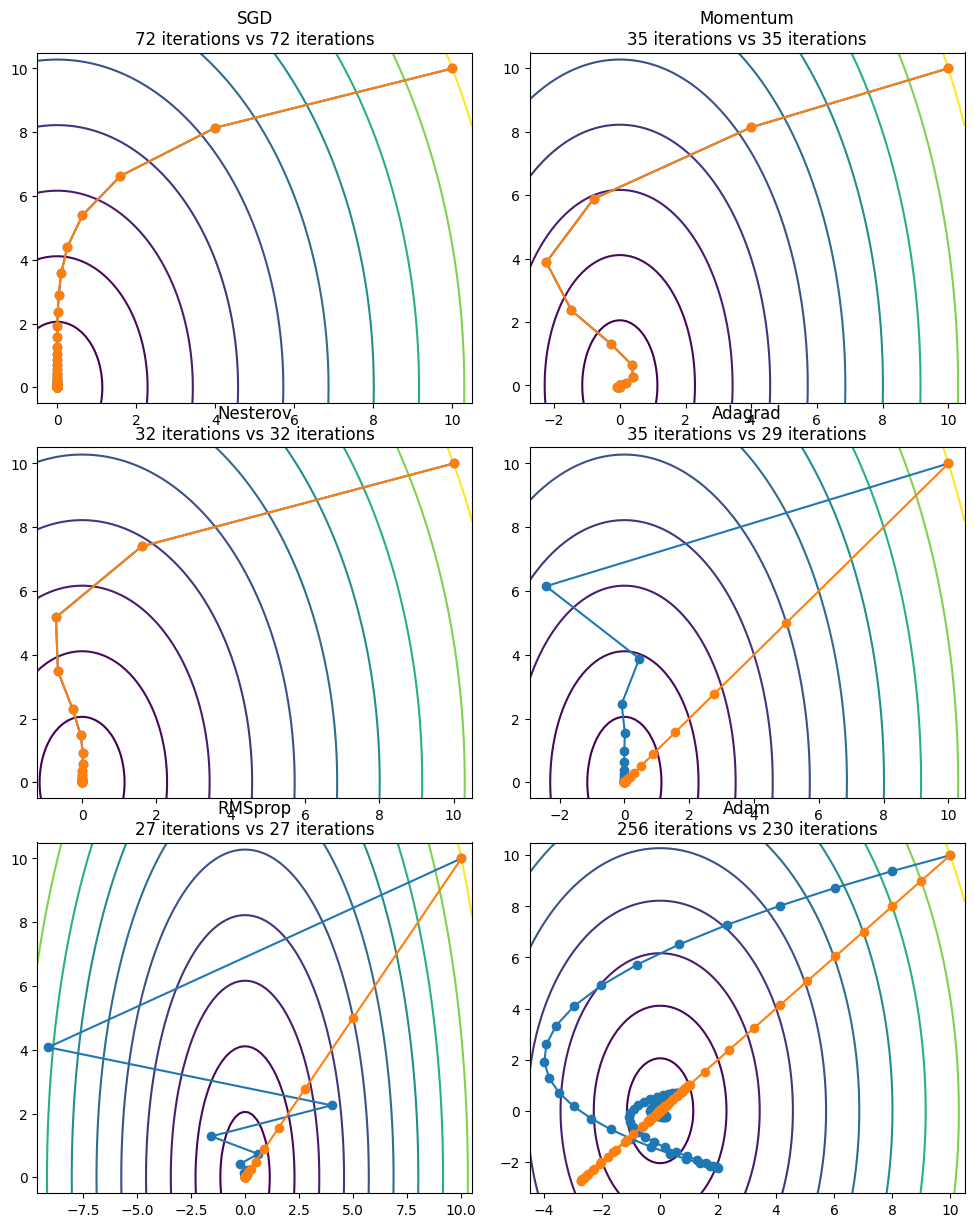

In [5]:
f = lambda x: 3 * x[0] ** 2 + 0.93 * x[1] ** 2 + 6 
x = np.array([10.0] * 2)
all_gds = [
    (partial(sgd, lr=0.1), partial(torch.optim.SGD, lr=0.1, momentum=0), "SGD"),
    (partial(momentum_gd, lr=0.1, momentum=0.4), partial(torch.optim.SGD, lr=0.1, momentum=0.4), "Momentum"),
    (partial(nesterov_gd, lr=0.1, momentum=0.4), partial(torch.optim.SGD, lr=0.1, momentum=0.4, nesterov=True), "Nesterov"),
    (partial(adagrad, lr=13), partial(torch.optim.Adagrad, lr=5), "Adagrad"),
    (partial(rmsprop, lr=2, beta=0.99), partial(torch.optim.RMSprop, lr=0.5, alpha=0.99), "RMSprop"),
    (partial(adam, lr=2.1, beta1=0.9, beta2=0.999), partial(torch.optim.Adam, lr=1, betas=(0.9, 0.999)), "Adam"),
]

fig, axs = plt.subplots(3, 2, figsize=(10, 12))
fig.tight_layout()

for gd, ax in zip(all_gds, axs.flatten()):
    my_gd, torch_gd, name = gd
    plot_both(x, f, ax, my_gd, torch_gd, name)


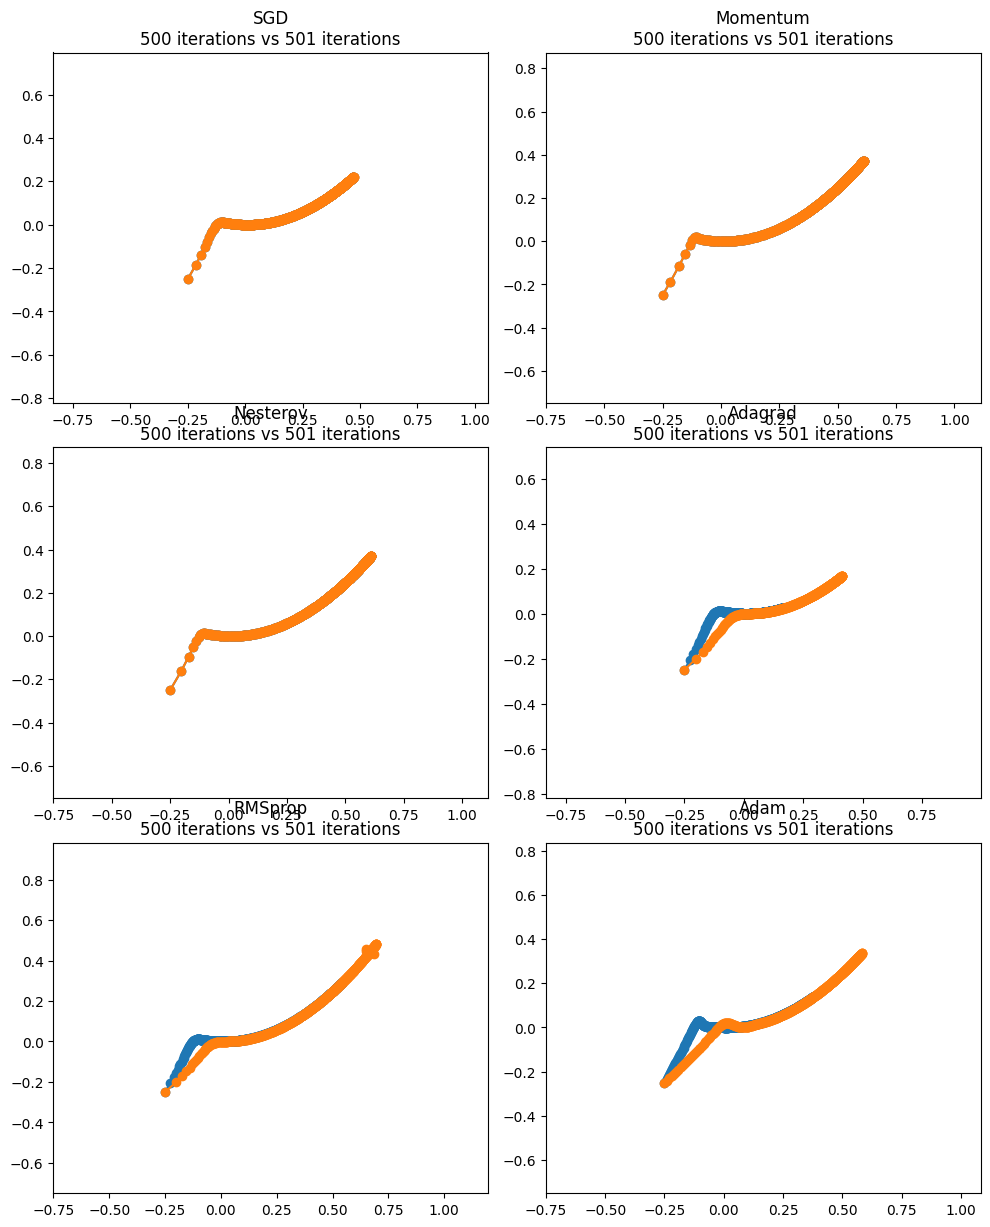

In [10]:
def f(x): # Rosenbrock function
    return 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2

x = np.array([-0.25,-0.25])
all_gds = [
    (partial(sgd, lr=0.001), partial(torch.optim.SGD, lr=0.001, momentum=0), "SGD"),
    (partial(momentum_gd, lr=0.001, momentum=0.4), partial(torch.optim.SGD, lr=0.001, momentum=0.4), "Momentum"),
    (partial(nesterov_gd, lr=0.001, momentum=0.4), partial(torch.optim.SGD, lr=0.001, momentum=0.4, nesterov=True), "Nesterov"),
    (partial(adagrad, lr=0.05), partial(torch.optim.Adagrad, lr=0.05), "Adagrad"),
    (partial(rmsprop, lr=0.005, beta=0.99), partial(torch.optim.RMSprop, lr=0.005, alpha=0.99), "RMSprop"),
    (partial(adam, lr=0.01, beta1=0.9, beta2=0.999), partial(torch.optim.Adam, lr=0.01, betas=(0.9, 0.999)), "Adam"),
]
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
fig.tight_layout()

for gd, ax in zip(all_gds, axs.flatten()):
    my_gd, torch_gd, name = gd
    plot_both(x, f, ax, my_gd, torch_gd, name)


In [7]:
f = lambda x: 3 * x[0] ** 2 + 0.93 * x[1] ** 2 + 6 
x = np.array([10.0] * 2)
iters = 25
all_gds = [
    (partial(sgd, lr=0.1), partial(torch.optim.SGD, lr=0.1, momentum=0), "SGD"),
    (partial(momentum_gd, lr=0.1, momentum=0.4), partial(torch.optim.SGD, lr=0.1, momentum=0.4), "Momentum"),
    (partial(nesterov_gd, lr=0.1, momentum=0.4), partial(torch.optim.SGD, lr=0.1, momentum=0.4, nesterov=True), "Nesterov"),
    (partial(adagrad, lr=13), partial(torch.optim.Adagrad, lr=5), "Adagrad"),
    (partial(rmsprop, lr=2, beta=0.99), partial(torch.optim.RMSprop, lr=0.5, alpha=0.99), "RMSprop"),
    (partial(adam, lr=2.1, beta1=0.9, beta2=0.999), partial(torch.optim.Adam, lr=1, betas=(0.9, 0.999)), "Adam"),
]

for gd, ax in zip(all_gds, axs.flatten()):
    my_gd, torch_gd, name = gd
    time_acc1 = time_acc2 = mem_acc1 = mem_acc2 = 0
    for _ in range(iters):
        result_1, result_2 = run_both(x, f, my_gd, torch_gd)
        time_acc1 += result_1.time
        time_acc2 += result_2.time
        mem_acc1 += result_1.peak_memory
        mem_acc2 += result_2.peak_memory

    print(f"""{name}:\n"""
          f"""\tPeak memory: {mem_acc1 / iters} vs {mem_acc2 / iters}\n"""
          f"""\tTime: {time_acc1 / iters} vs {time_acc2 / iters}""")


SGD:
	Peak memory: 74070.12 vs 15611.52
	Time: 0.44025153160095215 vs 0.0528300952911377
Momentum:
	Peak memory: 44648.24 vs 8980.44
	Time: 0.20338664054870606 vs 0.02642712593078613
Nesterov:
	Peak memory: 42526.28 vs 8362.48
	Time: 0.18676333427429198 vs 0.025326604843139647
Adagrad:
	Peak memory: 44333.08 vs 8191.2
	Time: 0.18940394401550292 vs 0.02302554130554199
RMSprop:
	Peak memory: 37673.76 vs 7409.08
	Time: 0.15793364524841308 vs 0.022052526473999023
Adam:
	Peak memory: 142363.84 vs 45147.28
	Time: 1.4582663440704347 vs 0.20367854118347167


## Task 2

[1.61171323 1.34553667]
[1.61171321 1.34553664]


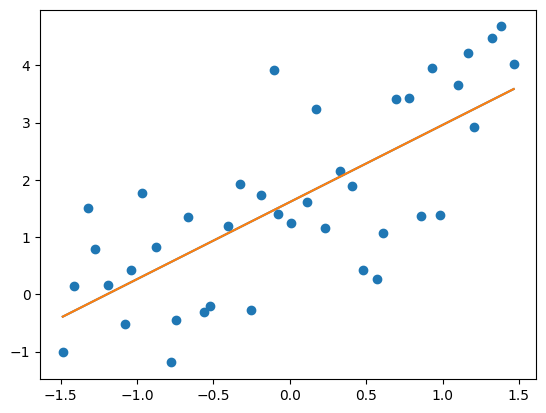

In [8]:
def run_scipy_method(p, points, method, lim=500):
    x = np.array([0] * (p + 1))
    result = method(gen_loss(points), x)
    return result.x

def run_both_regr(p, points, my_impl, scipy_impl):
    return run_f(lambda: my_impl(p, points)), run_f(lambda: run_scipy_method(p, points, scipy_impl))

def plot_both_regr(p, points, ax, src, my_impl, scipy_impl, name):
    ax.scatter(points[:, 0], points[:, 1])
    c1, c2 = run_both_regr(p, points, my_impl, scipy_impl)
    X = np.linspace(min(points[:, 0]), max(points[:, 0]), 100)
    # ax.plot(X, src(X))
    def gen_restore(c):
        def restore(x):
            # print(x, c)
            return sum(x ** i * c[i] for i in range(len(c)))
        
        return restore
    
    ax.plot(X, gen_restore(c1.result[0])(X))
    ax.plot(X, gen_restore(c2.result)(X))

    # print(c1.result[0])
    # print(c2.result)
    
    title = f"{name}"
    if ax == plt:
        ax.title(title)
    else:
        ax.set_title(title)

p = 1
points, src = gen_points_with_source_f(40, 1, np.exp)
plot_both_regr(
    p,
    points,
    plt,
    src,
    partial(poly_regression, gd=bfgs_gd),
    scipy.optimize.minimize,
    "",
)


[0.67849554 1.15829636 0.39554508]
[0.67849571 1.15829638 0.39554496]
[0.67849577 1.15829637 0.39554486]
[0.67849557 1.15829642 0.39554509]
[0.67849558 1.15829643 0.3955451 ]
[0.67860603 1.15825956 0.39545201]
[0.67849558 1.15829643 0.3955451 ]
[0.67857346 1.15827008 0.39549137]


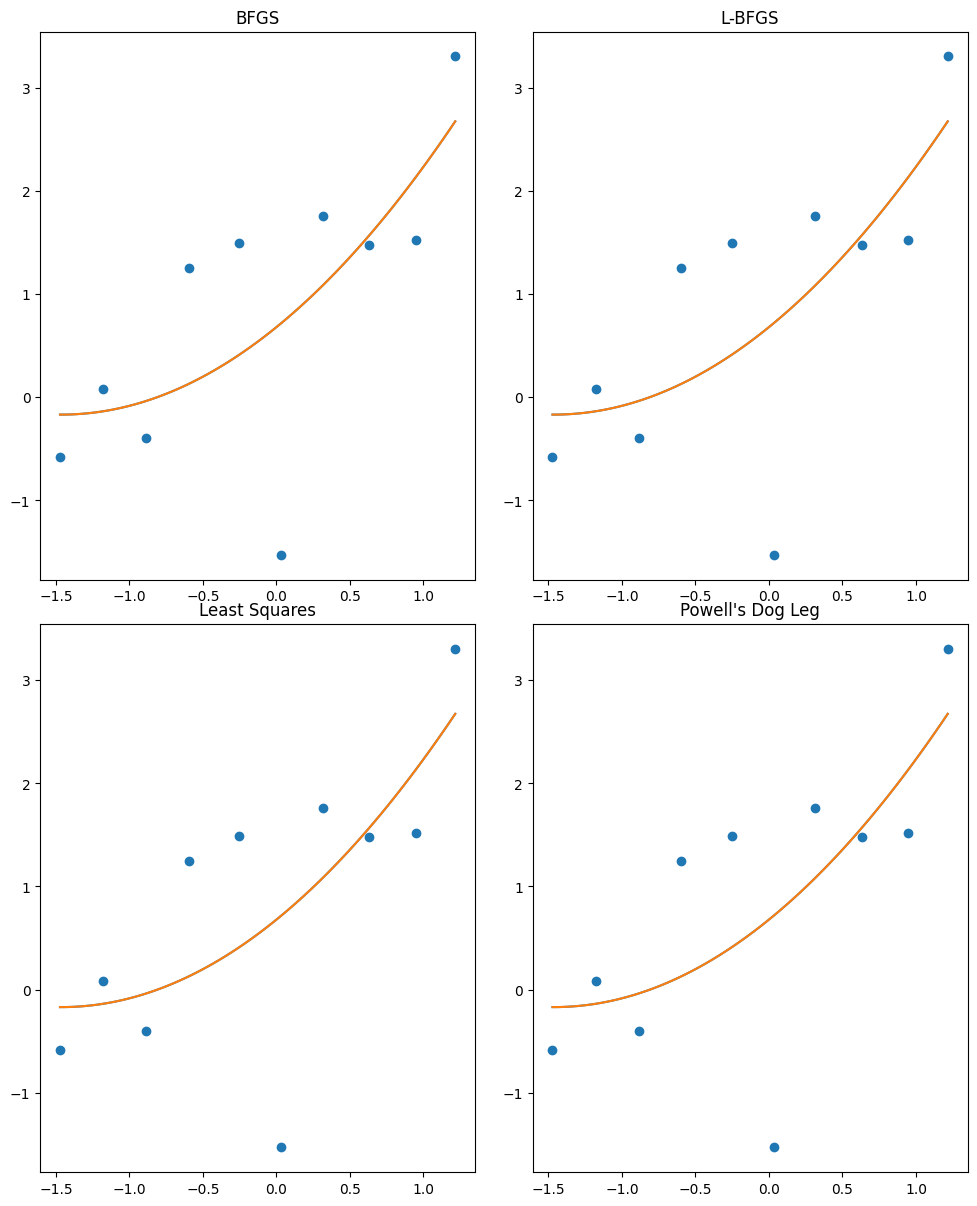

In [11]:
p = 2
points, src = gen_points_with_source_f(10, 1, np.exp)
all_regrs = [
    (partial(poly_regression, gd=bfgs_gd), partial(scipy.optimize.minimize, method="BFGS"), "BFGS"),
    (partial(poly_regression, gd=l_bfgs_gd), partial(scipy.optimize.minimize, method="L-BFGS-B"), "L-BFGS"), # unbounded L-BFGS-B == L-BFGS
    (gauss_newton, scipy.optimize.least_squares, "Least Squares"),
    (dog_leg, partial(scipy.optimize.least_squares, method="dogbox"), "Powell's Dog Leg"),
]

fig, axs = plt.subplots(2, 2, figsize=(10, 12))
fig.tight_layout()

for regr, ax in zip(all_regrs, axs.flatten()):
    my_regr, scipy_regr, name = regr
    plot_both_regr(p, points, ax, src, my_regr, scipy_regr, name)

In [14]:
p = 2
iters = 25
all_regrs = [
    (partial(poly_regression, gd=bfgs_gd), partial(scipy.optimize.minimize, method="BFGS"), "BFGS"),
    (partial(poly_regression, gd=l_bfgs_gd), partial(scipy.optimize.minimize, method="L-BFGS-B"), "L-BFGS"), # unbounded L-BFGS-B == L-BFGS
    (gauss_newton, scipy.optimize.least_squares, "Least Squares"),
    (dog_leg, partial(scipy.optimize.least_squares, method="dogbox"), "Powell's Dog Leg"),
]

for regr, ax in zip(all_regrs, axs.flatten()):
    my_regr, scipy_regr, name = regr
    time_acc1 = time_acc2 = mem_acc1 = mem_acc2 = 0
    for _ in range(iters):
        points, src = gen_points_with_source_f(10 + int(np.random.rand() * 30), np.random.rand() * 10, np.exp)
        result_1, result_2 = run_both_regr(p, points, my_regr, scipy_regr)
        time_acc1 += result_1.time
        time_acc2 += result_2.time
        mem_acc1 += result_1.peak_memory
        mem_acc2 += result_2.peak_memory

    print(f"""{name}:\n"""
          f"""\tPeak memory: {mem_acc1 / iters} vs {mem_acc2 / iters}\n"""
          f"""\tTime: {time_acc1 / iters} vs {time_acc2 / iters}""")

BFGS:
	Peak memory: 270272.96 vs 14357.88
	Time: 1.3195073223114013 vs 0.012906427383422852
L-BFGS:
	Peak memory: 119209.92 vs 23017.0
	Time: 2.2376146507263184 vs 0.008823375701904296
Least Squares:
	Peak memory: 104732.64 vs 11512.44
	Time: 0.015651445388793945 vs 0.03390982627868652
Powell's Dog Leg:
	Peak memory: 156694.24 vs 12930.08
	Time: 0.2264564037322998 vs 0.03281828880310059


## Task 2b

In [47]:
def timer(f):
    start = time.time()
    tracemalloc.start()
    result = f()
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tracemalloc.clear_traces()
    t = time.time() - start
    return result, t, peak_memory

def manual_grad(f, x):
    h = 1e-5
    l = f(x[:,np.newaxis] + h * np.eye(x.size))
    r = f(x[:,np.newaxis] - h * np.eye(x.size))
    return (l - r)/(2*h)

def ndt_grad(f, x):
    return grad(f, x)

def torch_grad(f, x):
    x = torch.tensor(x, requires_grad=True)
    y = f(x)
    y.backward()
    return x.grad.detach().numpy()

n = 10
p = 4
iters = 500
rands = [np.random.rand(p) for _ in range(iters)]
funcs = [lambda x: sum(sum(3 * rands[_][i] * x ** i for i in range(p))) for _ in range(iters)]
xs = [np.random.rand(n) * 3 for _ in range(iters)]

deviations = [0] * 3
times = [0] * 3
mems = [0] * 3
for f, x in zip(funcs, xs):
    ref_result, t, mem = timer(lambda: manual_grad(f, x))
    times[0], mems[0] = times[0] + t, mems[0] + mem
    
    result, t, mem = timer(lambda: ndt_grad(f, x))
    deviations[1], times[1], mems[1] = deviations[1] + np.linalg.norm(ref_result - result), times[1] + t, mems[1] + mem
    
    result, t, mem = timer(lambda: torch_grad(f, x))
    deviations[2], times[2], mems[2] = deviations[2] + np.linalg.norm(ref_result - result), times[2] + t, mems[2] + mem
    

deviations, times, mems = map(lambda l: '\t'.join(map(lambda x: str(x / iters), l)), [deviations, times, mems])
print(f"Methods: \tmanual\tnumdifftools\tpytorch\nDeviations:\t{deviations}\nTimes\t{times}\nMems:\t{mems}")

Methods: 	manual	numdifftools	pytorch
Deviations:	0.0	3.7550530081047064e-09	3.755031520075133e-09
Times	0.00022147130966186524	0.020092055797576905	0.0005742874145507812
Mems:	6632.0	22304.828	1281.69


## Task 2c

In [98]:
points, src = gen_points_with_source_f(10 + int(np.random.rand() * 30), np.random.rand() * 10, lambda x: 3 + 3 * x + 3 * x ** 2)
p = 2
iters = 100
lf = gen_loss(points)

bounds = [1, 3, 5, 10, 100]
for bound in bounds:
    print(f"Bound = [-{bound}, {bound}]:")
    all_regrs = [
        (gauss_newton, partial(scipy.optimize.least_squares, bounds=(-bound, bound)), "Least Squares"),
        (dog_leg, partial(scipy.optimize.least_squares, method="dogbox", bounds=(-bound, bound)), "Powell's Dog Leg"),
    ]
    for regr, ax in zip(all_regrs, axs.flatten()):
        my_regr, scipy_regr, name = regr
        loss_acc1 = loss_acc2 = time_acc1 = time_acc2 = mem_acc1 = mem_acc2 = 0
        for _ in range(iters):
            _, result_2 = run_both_regr(p, points, lambda _, __: (), scipy_regr)
            loss_acc2 += lf(result_2.result)
            time_acc2 += result_2.time
            mem_acc2 += result_2.peak_memory

        print(f"""\t{name}:\n"""
            f"""\t\tLoss: {loss_acc2 / iters}\n"""
            f"""\t\tPeak memory: {mem_acc2 / iters}\n"""
            f"""\t\tTime: {time_acc2 / iters}""")

Bound = [-1, 1]:
	Least Squares:
		Loss: 129.6072515934828
		Peak memory: 13205.9
		Time: 0.05309040546417236
	Powell's Dog Leg:
		Loss: 129.60725109177477
		Peak memory: 12942.47
		Time: 0.011897859573364257
Bound = [-3, 3]:
	Least Squares:
		Loss: 0.01609796097119442
		Peak memory: 13243.08
		Time: 0.09816377401351929
	Powell's Dog Leg:
		Loss: 0.016097886537401077
		Peak memory: 12978.62
		Time: 0.03085728645324707
Bound = [-5, 5]:
	Least Squares:
		Loss: 0.01336720847619615
		Peak memory: 12844.05
		Time: 0.1288021731376648
	Powell's Dog Leg:
		Loss: 0.013367208474529303
		Peak memory: 13177.31
		Time: 0.06948012590408326
Bound = [-10, 10]:
	Least Squares:
		Loss: 0.013367208509433197
		Peak memory: 12792.67
		Time: 0.09900376796722413
	Powell's Dog Leg:
		Loss: 0.013367208474529303
		Peak memory: 13132.24
		Time: 0.07675233602523804
Bound = [-100, 100]:
	Least Squares:
		Loss: 0.013367208480779724
		Peak memory: 12840.69
		Time: 0.10986510515213013
	Powell's Dog Leg:
		Loss: 0.013

## Bonus

In [90]:
x = [-30, 50]
def f(x): # Rosenbrock function
    return 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2

# y >= 0.5x (перекрываем долину в функции)
c1 = scipy.optimize.LinearConstraint(np.array([0.5, -1]), -np.inf, 0)
# y <= 2x (подталкиваем к точке минимума)
c2 = scipy.optimize.LinearConstraint(np.array([2, -1]), 0, np.inf)
# y <= x (проходим по точке минимума)
c3 = scipy.optimize.LinearConstraint(np.array([1, -1]), 0, np.inf)
# y >= x (проходим по точке минимума)
c4 = scipy.optimize.LinearConstraint(np.array([1, -1]), -np.inf, 0)
# y = x (проходим по точке минимума)
c5 = scipy.optimize.LinearConstraint(np.array([1, -1]), 0, 0)

# круг с радиусом 1 от (1, 1)
nlc1 = scipy.optimize.NonlinearConstraint(lambda x: (x[0] - 1) ** 2 + (x[1] - 1) ** 2, 0, 1)

# круг с радиусом 1 от (0, 1)
nlc2 = scipy.optimize.NonlinearConstraint(lambda x: (x[0]) ** 2 + (x[1] - 1) ** 2, 0, 1)

# круг с радиусом 1 от (0, 0)
nlc3 = scipy.optimize.NonlinearConstraint(lambda x: (x[0]) ** 2 + (x[1]) ** 2, 0, 1)

# вне круга с радиусом 1 от (1, 1)
nlc4 = scipy.optimize.NonlinearConstraint(lambda x: (x[0] - 1) ** 2 + (x[1] - 1) ** 2, 1, np.inf)

# вне круга с радиусом 1 от (0, 0)
nlc5 = scipy.optimize.NonlinearConstraint(lambda x: (x[0]) ** 2 + (x[1]) ** 2, 1, np.inf)

all_regrs = [
    (partial(scipy.optimize.minimize), "No constraints"),
    (partial(scipy.optimize.minimize, constraints=c1), "y >= 0.5x"),   
    (partial(scipy.optimize.minimize, constraints=c2), "y <= 2x"), 
    (partial(scipy.optimize.minimize, constraints=c3), "y <= x"), 
    (partial(scipy.optimize.minimize, constraints=c4), "y >= x"),       
    (partial(scipy.optimize.minimize, constraints=c5), "y = x"),       
    (partial(scipy.optimize.minimize, constraints=nlc1), "B((1, 1), 1)"), 
    (partial(scipy.optimize.minimize, constraints=nlc2), "B((0, 1), 1)"), 
    (partial(scipy.optimize.minimize, constraints=nlc3), "B((0, 0), 1)"), 
    (partial(scipy.optimize.minimize, constraints=nlc4), "not B((1, 1), 1)"), 
    (partial(scipy.optimize.minimize, constraints=nlc5), "not B((0, 0), 1)"), 
]

for regr, name in all_regrs:
    result, t, mem = timer(lambda: regr(f, x))
    print(f"{name}:\n\tx = {result.x}\n\tnit = {result.nit}\n\ttime = {t}\n\tmem = {mem}")


No constraints:
	x = [0.99999554 0.99999108]
	nit = 172
	time = 0.4579734802246094
	mem = 14325
y >= 0.5x:
	x = [0.05415444 0.02707722]
	nit = 67
	time = 0.13366055488586426
	mem = 18553
y <= 2x:
	x = [0.99958516 0.99915858]
	nit = 34
	time = 0.06503057479858398
	mem = 18055
y <= x:
	x = [0.99996375 0.9999181 ]
	nit = 36
	time = 0.08308529853820801
	mem = 21268
y >= x:
	x = [ 5.55086081 30.80900846]
	nit = 100
	time = 0.18846607208251953
	mem = 18585
y = x:
	x = [1.00005433 1.00005433]
	nit = 18
	time = 0.03253793716430664
	mem = 20119
B((1, 1), 1):
	x = [0.99956968 0.99913732]
	nit = 37
	time = 0.10724496841430664
	mem = 20995
B((0, 1), 1):
	x = [0.99996723 0.99992642]
	nit = 44
	time = 0.11891651153564453
	mem = 20552
B((0, 0), 1):
	x = [0.7864003  0.61771727]
	nit = 45
	time = 0.11520957946777344
	mem = 24083
not B((1, 1), 1):
	x = [0.42815805 0.17963618]
	nit = 75
	time = 0.20479249954223633
	mem = 20400
not B((0, 0), 1):
	x = [-0.78393032  0.62084883]
	nit = 61
	time = 0.180056571

In [94]:
x = [-30, 50]
def f(x):
    return (x[0] - 1) ** 2 + (x[1] - 1) ** 4

# y >= 0.5x
c1 = scipy.optimize.LinearConstraint(np.array([0.5, -1]), -np.inf, 0)
# y <= 2x 
c2 = scipy.optimize.LinearConstraint(np.array([2, -1]), 0, np.inf)
# y <= x 
c3 = scipy.optimize.LinearConstraint(np.array([1, -1]), 0, np.inf)
# y >= x 
c4 = scipy.optimize.LinearConstraint(np.array([1, -1]), -np.inf, 0)
# y = x 
c5 = scipy.optimize.LinearConstraint(np.array([1, -1]), 0, 0)

# круг с радиусом 1 от (1, 1)
nlc1 = scipy.optimize.NonlinearConstraint(lambda x: (x[0] - 1) ** 2 + (x[1] - 1) ** 2, 0, 1)

# круг с радиусом 1 от (0, 1)
nlc2 = scipy.optimize.NonlinearConstraint(lambda x: (x[0]) ** 2 + (x[1] - 1) ** 2, 0, 1)

# круг с радиусом 1 от (0, 0)
nlc3 = scipy.optimize.NonlinearConstraint(lambda x: (x[0]) ** 2 + (x[1]) ** 2, 0, 1)

# вне круга с радиусом 1 от (1, 1)
nlc4 = scipy.optimize.NonlinearConstraint(lambda x: (x[0] - 1) ** 2 + (x[1] - 1) ** 2, 1, np.inf)

# вне круга с радиусом 1 от (0, 0)
nlc5 = scipy.optimize.NonlinearConstraint(lambda x: (x[0]) ** 2 + (x[1]) ** 2, 1, np.inf)

all_regrs = [
    (partial(scipy.optimize.minimize), "No constraints"),
    (partial(scipy.optimize.minimize, constraints=c1), "y >= 0.5x"),   
    (partial(scipy.optimize.minimize, constraints=c2), "y <= 2x"), 
    (partial(scipy.optimize.minimize, constraints=c3), "y <= x"), 
    (partial(scipy.optimize.minimize, constraints=c4), "y >= x"),       
    (partial(scipy.optimize.minimize, constraints=c5), "y = x"),       
    (partial(scipy.optimize.minimize, constraints=nlc1), "B((1, 1), 1)"), 
    (partial(scipy.optimize.minimize, constraints=nlc2), "B((0, 1), 1)"), 
    (partial(scipy.optimize.minimize, constraints=nlc3), "B((0, 0), 1)"), 
    (partial(scipy.optimize.minimize, constraints=nlc4), "not B((1, 1), 1)"), 
    (partial(scipy.optimize.minimize, constraints=nlc5), "not B((0, 0), 1)"), 
]

for regr, name in all_regrs:
    result, t, mem = timer(lambda: regr(f, x))
    print(f"{name}:\n\tx = {result.x}\n\tnit = {result.nit}\n\ttime = {t}\n\tmem = {mem}")


No constraints:
	x = [1.         1.01249282]
	nit = 30
	time = 0.12906193733215332
	mem = 14021
y >= 0.5x:
	x = [0.99999965 1.20331129]
	nit = 4
	time = 0.026274919509887695
	mem = 18537
y <= 2x:
	x = [0.99999999 1.02798943]
	nit = 22
	time = 0.061676740646362305
	mem = 18191
y <= x:
	x = [1.00025143 1.00025143]
	nit = 15
	time = 0.03031325340270996
	mem = 18191
y >= x:
	x = [0.99999999 1.02799553]
	nit = 26
	time = 0.05030536651611328
	mem = 18055
y = x:
	x = [1.00000078 1.00000078]
	nit = 19
	time = 0.03960752487182617
	mem = 20981
B((1, 1), 1):
	x = [0.99999987 1.03150579]
	nit = 25
	time = 0.08475208282470703
	mem = 21050
B((0, 1), 1):
	x = [0.99999743 1.00241273]
	nit = 32
	time = 0.08494806289672852
	mem = 20552
B((0, 0), 1):
	x = [0.8085102  0.58848217]
	nit = 23
	time = 0.056748151779174805
	mem = 23481
not B((1, 1), 1):
	x = [1.70710678 1.70710679]
	nit = 20
	time = 0.0578150749206543
	mem = 20866
not B((0, 0), 1):
	x = [0.99999999 1.03140035]
	nit = 25
	time = 0.0614285469055